In [ ]:
import librosa
import numpy as np
import os
import pandas as pd

In [ ]:
# Feature Extraction Functions

# 1. Energy and Power
def extract_energy(speech):
    return librosa.feature.rms(y=speech)[0]  # Root mean square energy

# 2. Pitch (Fundamental Frequency) Statistics
def extract_pitch(speech, rate):
    pitch, _ = librosa.core.piptrack(y=speech, sr=rate)
    pitch = pitch[pitch > 0]  # Remove zero values
    return pitch

# 3. Pitch Statistics
def pitch_stats(pitch):
    min_pitch = np.min(pitch)
    max_pitch = np.max(pitch)
    mean_pitch = np.mean(pitch)
    pitch_sd = np.std(pitch)
    pitch_abs = np.mean(np.abs(pitch))
    pitch_quant = np.quantile(pitch, [0.25, 0.5, 0.75])
    diff_pitch_max_min = max_pitch - min_pitch
    diff_pitch_max_mean = max_pitch - mean_pitch
    diff_pitch_max_mode = max_pitch - np.median(pitch)
    return min_pitch, max_pitch, mean_pitch, pitch_sd, pitch_abs, pitch_quant, diff_pitch_max_min, diff_pitch_max_mean, diff_pitch_max_mode

# 4. Intensity (RMS)
def intensity_features(speech):
    intensity = librosa.feature.rms(y=speech)[0]
    intensity_min = np.min(intensity)
    intensity_max = np.max(intensity)
    intensity_mean = np.mean(intensity)
    intensity_sd = np.std(intensity)
    intensity_quant = np.quantile(intensity, [0.25, 0.5, 0.75])
    diff_int_max_min = intensity_max - intensity_min
    diff_int_max_mean = intensity_max - intensity_mean
    diff_int_max_mode = intensity_max - np.median(intensity)
    return intensity_min, intensity_max, intensity_mean, intensity_sd, intensity_quant, diff_int_max_min, diff_int_max_mean, diff_int_max_mode

# 5. Jitter and Shimmer
def jitter_shimmer(speech, rate):
    # Jitter: Measure of pitch variation
    pitch, voiced_flag = librosa.core.piptrack(y=speech, sr=rate)
    jitter = np.std(pitch[pitch > 0])
    
    # Shimmer: Measure of amplitude variation (calculated based on RMS)
    intensity = librosa.feature.rms(y=speech)[0]
    shimmer = np.std(intensity)
    
    return jitter, shimmer

# 6. Speech Rate and Pauses
def speech_rate(speech, rate):
    onset_env = librosa.onset.onset_strength(y=speech, sr=rate)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=rate)
    speak_rate = len(onset_frames) / (len(speech) / rate)  # Onsets per second
    return speak_rate

def pause_features(speech, rate):
    onset_env = librosa.onset.onset_strength(y=speech, sr=rate)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=rate)
    intervals = librosa.frames_to_time(onset_frames, sr=rate)  # Time intervals between onsets
    pauses = np.diff(intervals)  # Calculate pause durations
    max_pause = np.max(pauses) if len(pauses) > 0 else 0
    avg_pause = np.mean(pauses) if len(pauses) > 0 else 0
    total_pause_duration = np.sum(pauses)
    return max_pause, avg_pause, total_pause_duration

# 7. Rising and Falling Edges (Pitch changes)
def rising_falling_edges(pitch):
    rising = np.sum(np.diff(pitch) > 0)
    falling = np.sum(np.diff(pitch) < 0)
    max_rising = np.max(np.diff(pitch)[np.diff(pitch) > 0]) if len(np.diff(pitch)) > 0 else 0
    max_falling = np.min(np.diff(pitch)[np.diff(pitch) < 0]) if len(np.diff(pitch)) > 0 else 0
    avg_rise = np.mean(np.diff(pitch)[np.diff(pitch) > 0]) if len(np.diff(pitch)) > 0 else 0
    avg_fall = np.mean(np.diff(pitch)[np.diff(pitch) < 0]) if len(np.diff(pitch)) > 0 else 0
    return rising, falling, max_rising, max_falling, avg_rise, avg_fall

# 8. Loudness (RMS energy)
def loudness(speech):
    return librosa.feature.rms(y=speech)[0]


In [ ]:
def getScoreForMITVideo(df, person_id, column_name):
    """
    Calculate the average score for a given person and column.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        person_id (str): The participant ID (e.g., "p1").
        column_name (str): The name of the column to average (e.g., "Overall").

    Returns:
        float: The average score for the specified column and person.
    """
    person_data = df[df["Participant"] == person_id]
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in dataframe.")
    if person_data.empty:
        raise ValueError(f"No data found for participant '{person_id}'.")
    
    averageScore = person_data[column_name].astype(float).mean()
    
    return averageScore / 7.0  # Normalize the score to a scale of 0-1


In [ ]:
# Step 1: Create an empty DataFrame
df = pd.DataFrame(columns=['Filename', 'Energy', 'Pitch Min', 'Pitch Max', 'Pitch Mean', 'Pitch Std Dev', 'Intensity Min', 'Intensity Max', 'Intensity Mean', 'Jitter', 'Shimmer', 'Speech Rate', 'Max Pause', 'Avg Pause', 'Result'])


df_labels_from_turkers = pd.read_csv('../MIT_INTERVIEW_DATASET/Labels/turker_scores_full_interview.csv')

In [ ]:
# Create a DataFrame to store the features

# I want this dataframe to have the following columns:
# 'Energy', 'Pitch Min', 'Pitch Max', 'Pitch Mean', 'Pitch Std Dev', 'Intensity Min', 'Intensity Max', 'Intensity Mean', 'Jitter', 'Shimmer', 'Speech Rate', 'Max Pause', 'Avg Pause', 

# The first column should be the filename of the audio file
# The last column should be whether they passed or failed the interview, for now just set it to 'pass'




# Step 2: Loop through the audio files and extract features


def addDataFromMIT(rows):
    # Processing MIT interview dataset
    for i in range(15):
        AUDIO_FILE = f'../MIT_INTERVIEW_DATASET/Audio/P{i}.wav'
        if os.path.exists(AUDIO_FILE):
            speech, rate = librosa.load(AUDIO_FILE, sr=16000)
            energy = extract_energy(speech)
            pitch = extract_pitch(speech, rate)
            min_pitch, max_pitch, mean_pitch, pitch_sd, *_ = pitch_stats(pitch)
            intensity_min, intensity_max, intensity_mean, *_ = intensity_features(speech)
            jitter, shimmer = jitter_shimmer(speech, rate)
            speak_rate = speech_rate(speech, rate)
            max_pause, avg_pause, total_pause_duration = pause_features(speech, rate)
            
            rowNameFromTurkers = f"p{i}"
            columnNameFromTurkers = "Overall"
            score = getScoreForMITVideo(df_labels_from_turkers, rowNameFromTurkers, columnNameFromTurkers)

            print(f"passOrFail: {score}")


            rows.append({
                'Filename': AUDIO_FILE,
                'Energy': np.mean(energy),
                'Pitch Min': min_pitch,
                'Pitch Max': max_pitch,
                'Pitch Mean': mean_pitch,
                'Pitch Std Dev': pitch_sd,
                'Intensity Min': intensity_min,
                'Intensity Max': intensity_max,
                'Intensity Mean': intensity_mean,
                'Jitter': jitter,
                'Shimmer': shimmer,
                'Speech Rate': speak_rate,
                'Max Pause': max_pause,
                'Avg Pause': avg_pause,
                'Result': score
            })
        

        AUDIO_FILE = f'../MIT_INTERVIEW_DATASET/Audio/PP{i}.wav'
        if os.path.exists(AUDIO_FILE):
            speech, rate = librosa.load(AUDIO_FILE, sr=16000)
            energy = extract_energy(speech)
            pitch = extract_pitch(speech, rate)
            min_pitch, max_pitch, mean_pitch, pitch_sd, *_ = pitch_stats(pitch)
            intensity_min, intensity_max, intensity_mean, *_ = intensity_features(speech)
            jitter, shimmer = jitter_shimmer(speech, rate)
            speak_rate = speech_rate(speech, rate)
            max_pause, avg_pause, total_pause_duration = pause_features(speech, rate)
            
            rowNameFromTurkers = f"p{i}"
            columnNameFromTurkers = "Overall"
            score = getScoreForMITVideo(df_labels_from_turkers, rowNameFromTurkers, columnNameFromTurkers)

            print(f"passOrFail: {score}")


            rows.append({
                'Filename': AUDIO_FILE,
                'Energy': np.mean(energy),
                'Pitch Min': min_pitch,
                'Pitch Max': max_pitch,
                'Pitch Mean': mean_pitch,
                'Pitch Std Dev': pitch_sd,
                'Intensity Min': intensity_min,
                'Intensity Max': intensity_max,
                'Intensity Mean': intensity_mean,
                'Jitter': jitter,
                'Shimmer': shimmer,
                'Speech Rate': speak_rate,
                'Max Pause': max_pause,
                'Avg Pause': avg_pause,
                'Result': score
            })





In [ ]:
import pickle as pkl
import pandas as pd
import os

os.makedirs('DatasetRelatedFiles', exist_ok=True)

def pickleToCSV(pathToPickleFile = r'DatasetRelatedFiles/FirstImpressionDataset.pkl'):
    with open(pathToPickleFile, "rb") as f:
        object = pkl.load(f, encoding='latin1')
        
    df = pd.DataFrame(object)
    df.index.name = 'filename'
    df.to_csv(r'./DatasetRelatedFiles/FirstImpressionDataset.csv', index=True)
    print("DataFrame is saved to CSV file.")
    return df



In [ ]:
pickleToCSV()

In [29]:
# Processing the First Impressions V2 Dataset

# Get all the files from the directory: ../FirstImpression-V2-Dataset
# Then go through each video and extract the audio

csv_file_path = r'./DatasetRelatedFiles/FirstImpressionDataset.csv'
df = pd.read_csv(csv_file_path)
df = df.reset_index()
print(df.head())


   index             filename  extraversion  neuroticism  agreeableness  \
0      0  J4GQm9j0JZ0.003.mp4      0.523364     0.552083       0.626374   
1      1  zEyRyTnIw5I.005.mp4      0.345794     0.375000       0.472527   
2      2  nskJh7v6v1U.004.mp4      0.252336     0.291667       0.406593   
3      3  6wHQsN5g2RM.000.mp4      0.457944     0.489583       0.505495   
4      4  dQOeQYWIgm8.000.mp4      0.607477     0.489583       0.406593   

   conscientiousness  interview  openness  
0           0.601942   0.504673  0.488889  
1           0.582524   0.457944  0.366667  
2           0.485437   0.373832  0.511111  
3           0.398058   0.457944  0.377778  
4           0.621359   0.570093  0.622222  


In [ ]:
# Loop through the audio files and extract features

# There is a folder called FirstImpression-V2-Dataset 
# Inside that folder are 6 train folders
# Inside each train folder are a series of folders
# Inside each folder are a series of videos


def addDataFromFirstImpressionV2(rows):

    # Here is the path to the FirstImpression-V2-Dataset 
    firstImpressionV2DatasetPath = r'../FirstImpression-V2-Dataset'
    # Check if it exists
    if not os.path.exists(firstImpressionV2DatasetPath):
        raise ValueError(f"Path {firstImpressionV2DatasetPath} does not exist.")

    # now loop through the folders inside the FirstImpression-V2-Dataset


    for folder in os.listdir(firstImpressionV2DatasetPath):
        # print(f"Processing folder: {folder}")
        numSubfoldersGoneThrough = 0
        for subfolder in os.listdir(os.path.join(firstImpressionV2DatasetPath, folder)):
            # print(f"Processing subfolder: {subfolder}")
            numSubfoldersGoneThrough += 1
            
            if numSubfoldersGoneThrough > 1:
                break
            for video_file in os.listdir(os.path.join(firstImpressionV2DatasetPath, folder, subfolder)):
   

     
                if video_file.endswith('.mp4'):
                    video_path = os.path.join(firstImpressionV2DatasetPath, folder, subfolder, video_file)
                    video_name = os.path.splitext(video_file)[0] + '.mp4'
                    print(f"Processing video: {video_name}")
            
                    audio_path = os.path.splitext(video_path)[0] + '.wav'
                    
    
                    os.system(f'ffmpeg -y -loglevel error -i "{video_path}" -vn -acodec pcm_s16le -ar 44100 -ac 1 "{audio_path}" > /dev/null 2>&1')
                    
                    try:
                        if video_name in df['filename'].values:
               
                            speech, rate = librosa.load(audio_path, sr=16000)
                            energy = extract_energy(speech)
                            pitch = extract_pitch(speech, rate)
                            min_pitch, max_pitch, mean_pitch, pitch_sd, *_ = pitch_stats(pitch)
                            intensity_min, intensity_max, intensity_mean, *_ = intensity_features(speech)
                            jitter, shimmer = jitter_shimmer(speech, rate)
                            speak_rate = speech_rate(speech, rate)
                            max_pause, avg_pause, _ = pause_features(speech, rate)
                            
                    
                            score = df.loc[df['filename'] == video_name, 'interview'].values[0]
                            print(f"Score: {score}")
                                
              
                            rows.append({
                                'Filename': video_name,
                                'Energy': np.mean(energy),
                                'Pitch Min': min_pitch,
                                'Pitch Max': max_pitch,
                                'Pitch Mean': mean_pitch,
                                'Pitch Std Dev': pitch_sd,
                                'Intensity Min': intensity_min,
                                'Intensity Max': intensity_max,
                                'Intensity Mean': intensity_mean,
                                'Jitter': jitter,
                                'Shimmer': shimmer,
                                'Speech Rate': speak_rate,
                                'Max Pause': max_pause,
                                'Avg Pause': avg_pause,
                                'Result': score
                            })
                            
                            
                      
                    
                    finally:
     
                        if os.path.exists(audio_path):
                            os.remove(audio_path)
                            print(f"Deleted temporary file: {audio_path}")

        
        break
                     

In [ ]:
rows = []
addDataFromMIT(rows)

In [33]:
addDataFromFirstImpressionV2(rows)

Processing video: gUyH1qvbOZA.004.mp4
Score: 0.7383177570093457
{'Filename': 'gUyH1qvbOZA.004.mp4', 'Energy': np.float32(0.12073329), 'Pitch Min': np.float32(153.13274), 'Pitch Max': np.float32(3996.015), 'Pitch Mean': np.float32(1670.1344), 'Pitch Std Dev': np.float32(1152.6804), 'Intensity Min': np.float32(0.0010972925), 'Intensity Max': np.float32(0.26846987), 'Intensity Mean': np.float32(0.12073329), 'Jitter': np.float32(1152.6804), 'Shimmer': np.float32(0.06253862), 'Speech Rate': 6.992549993464907, 'Max Pause': np.float64(0.7040000000000006), 'Avg Pause': np.float64(0.14218867924528303), 'Result': np.float64(0.7383177570093457)}
Deleted temporary file: ../FirstImpression-V2-Dataset/train-1/training80_06/gUyH1qvbOZA.004.wav
Processing video: mlXZQ8dO0nQ.005.mp4
Score: 0.4672897196261681
{'Filename': 'mlXZQ8dO0nQ.005.mp4', 'Energy': np.float32(0.085710265), 'Pitch Min': np.float32(152.44942), 'Pitch Max': np.float32(3995.7634), 'Pitch Mean': np.float32(1624.3075), 'Pitch Std Dev': 

In [34]:
# Now create DataFrame
df = pd.DataFrame(rows)

# df.to_csv('../2-VocalTone-(Prosody)/prosodic_features_from_MIT_videos_with_results.csv', index=False)

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv('../2-VocalTone-(Prosody)/final_dataset_without_binarizing.csv')

# Filter MIT dataset
mit_mask = df['Filename'].str.contains("MIT_INTERVIEW_DATASET", case=False)
df_mit = df[mit_mask]

# Prepare data
X = df_mit.drop(columns=["Filename", "Result"])
y = df_mit["Result"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train regressor
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = reg.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


Mean Squared Error: 0.005915995070464069
R² Score: 0.22780999520884326


### Evaluation Metrics



In [3]:
loaded_model = reg

In [12]:
import joblib

# Save model
joblib.dump(loaded_model, "./DatasetRelatedFiles/models/regression_model.pkl")

# Load model later
loaded_model = joblib.load("./DatasetRelatedFiles/models/regression_model.pkl")


Mean Squared Error: 0.0059
R² Score: 0.2278


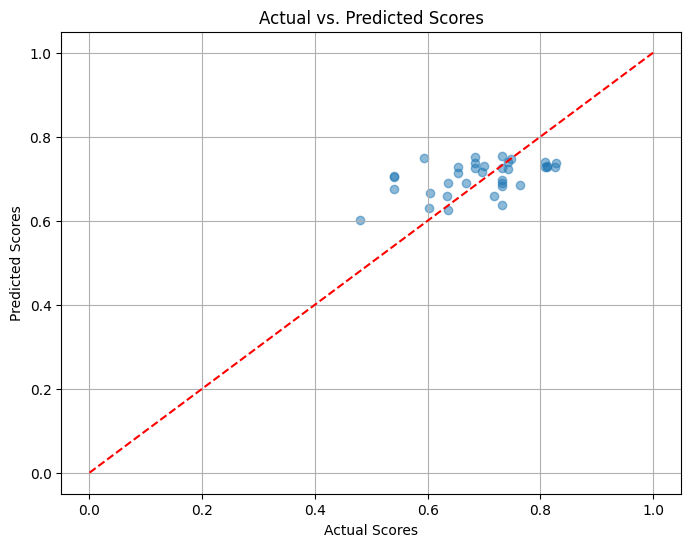

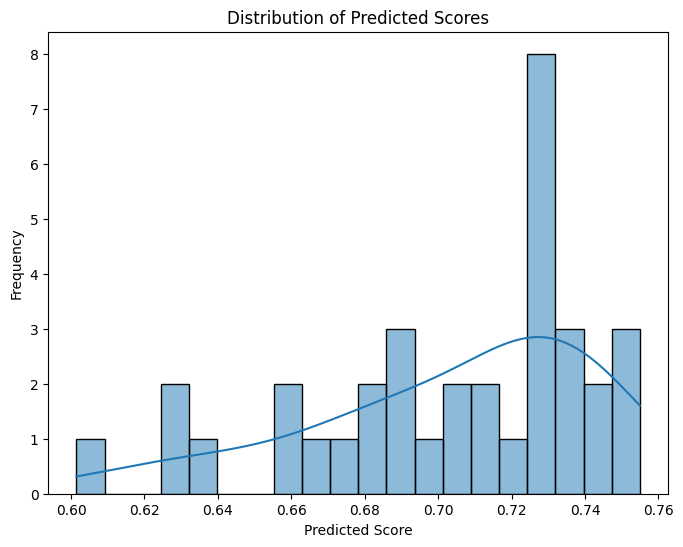

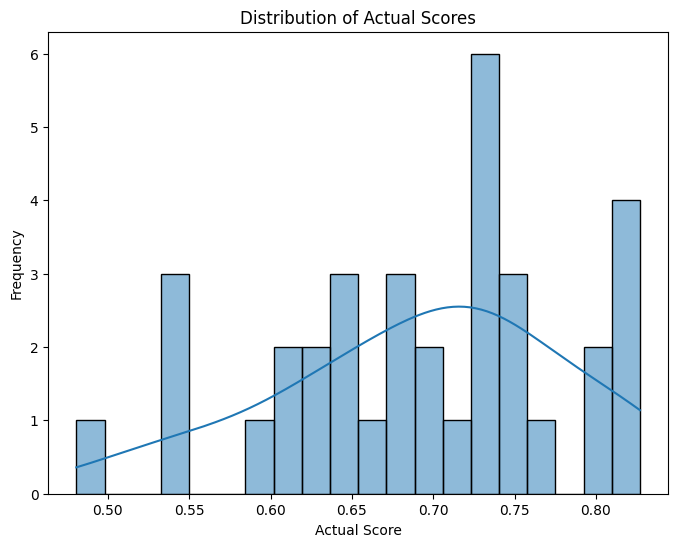

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

y_pred_scores = loaded_model.predict(X_test) 
y_pred_scores = np.clip(y_pred_scores, 0.0, 1.0)   

mse = mean_squared_error(y_test, y_pred_scores)
r2 = r2_score(y_test, y_pred_scores)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_scores, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # Ideal line (y = x)
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs. Predicted Scores')
plt.grid(True)
plt.show()
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_scores, bins=20, kde=True)
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Scores')
plt.show()


plt.figure(figsize=(8, 6))
sns.histplot(y_test, bins=20, kde=True)
plt.xlabel('Actual Score')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Scores')
plt.show()


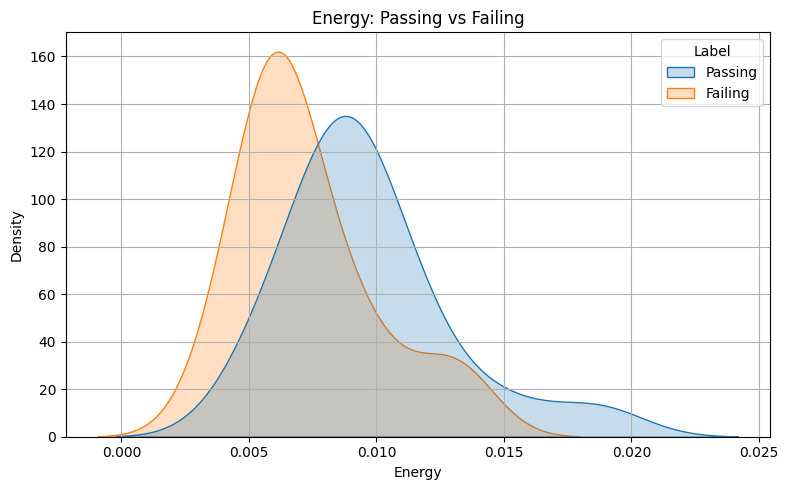

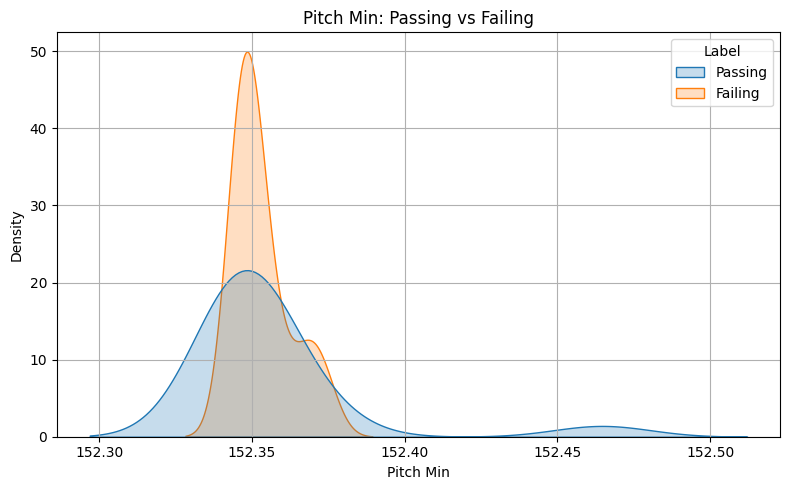

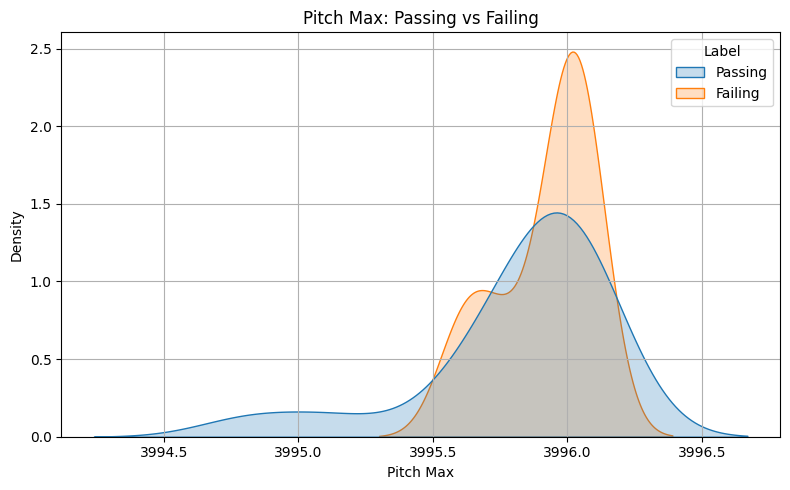

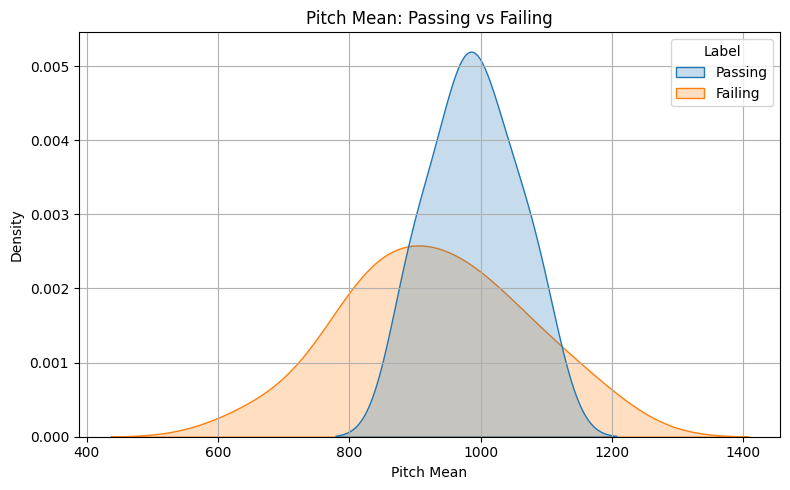

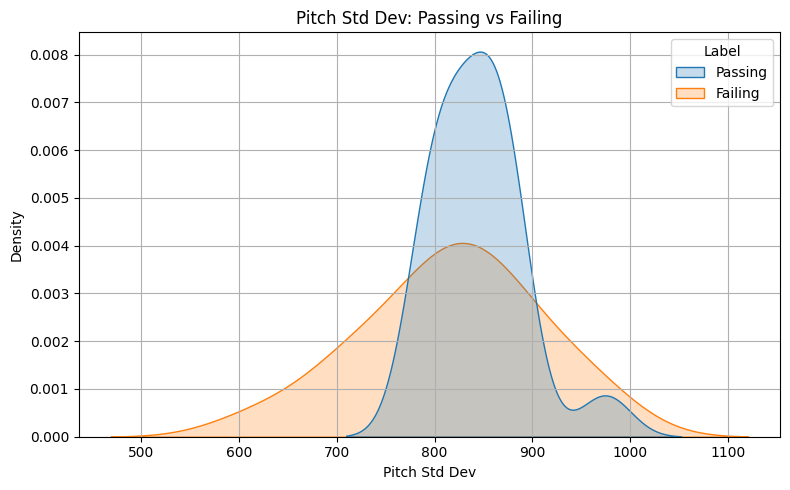

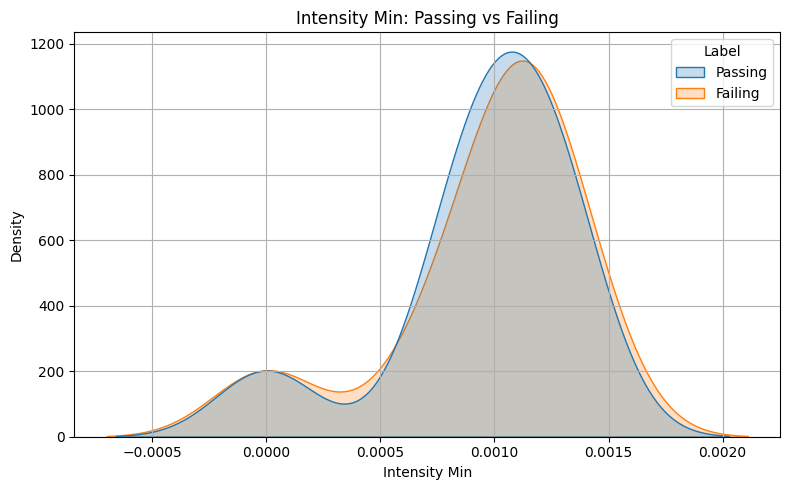

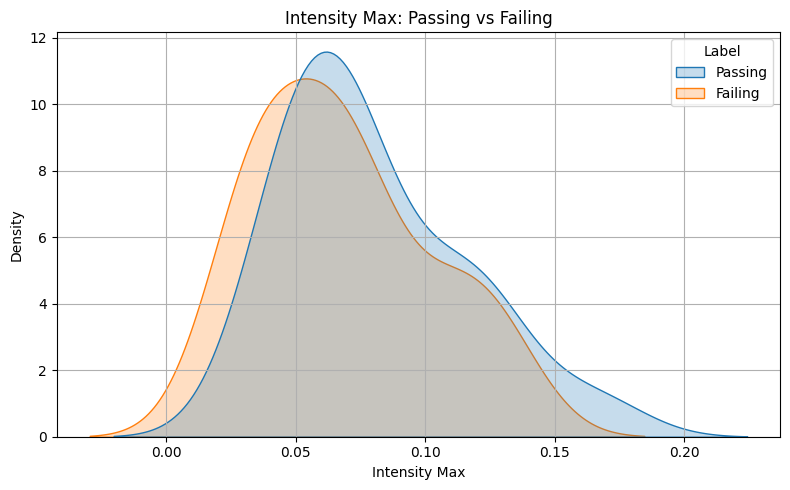

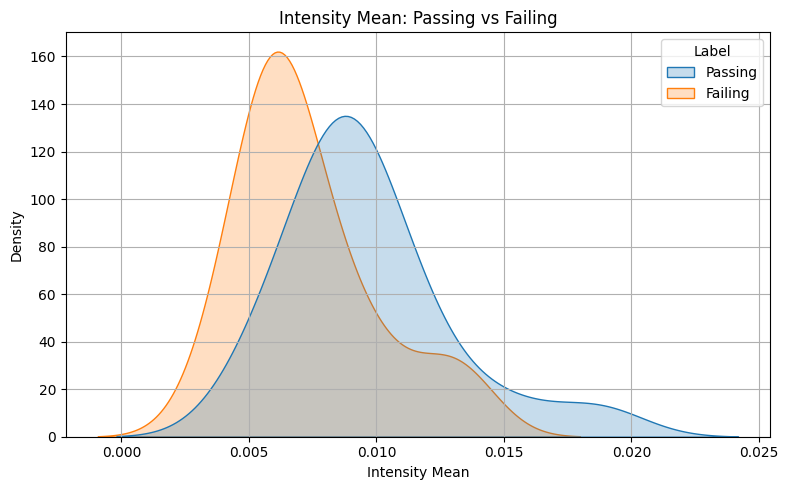

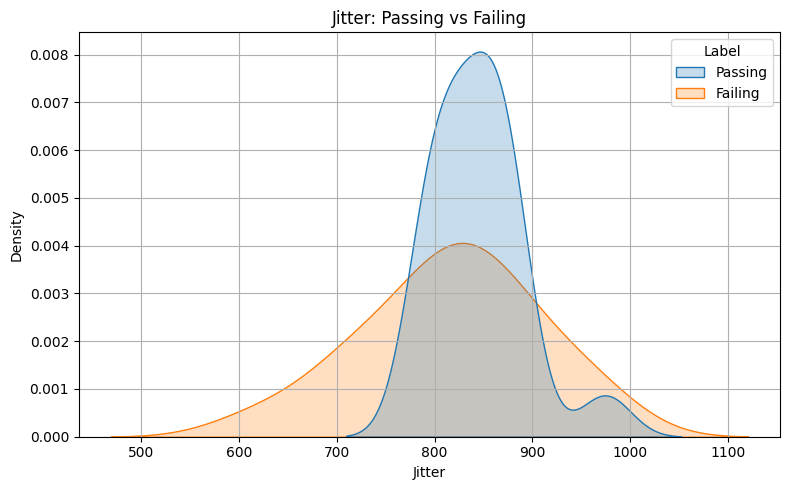

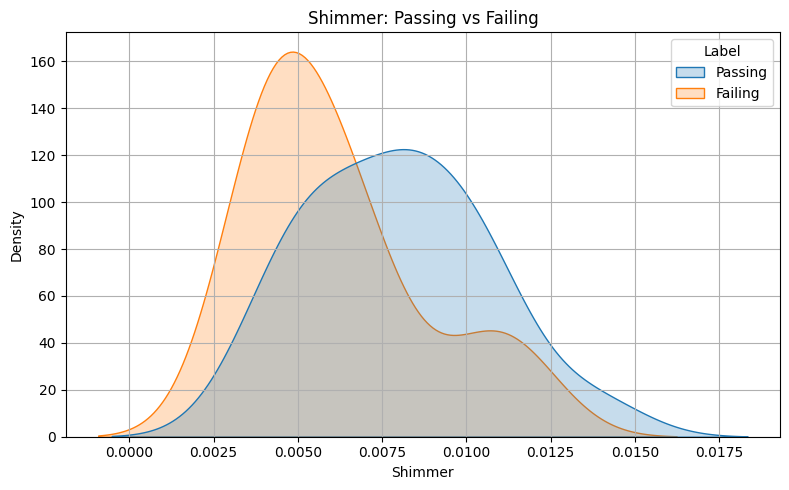

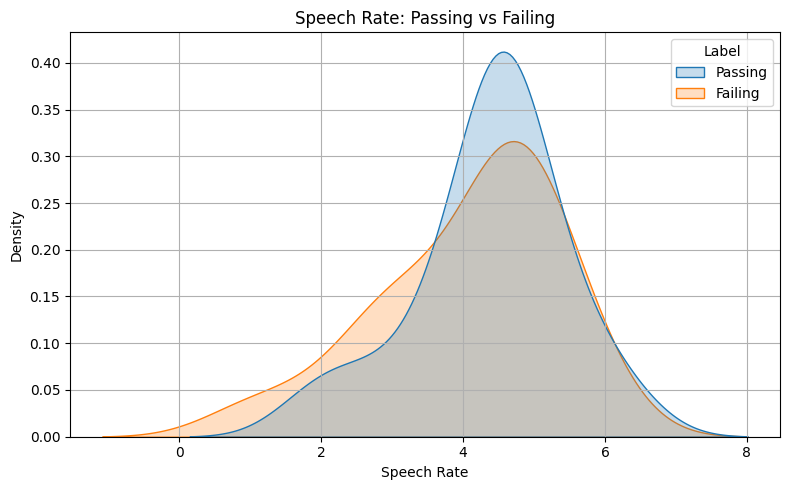

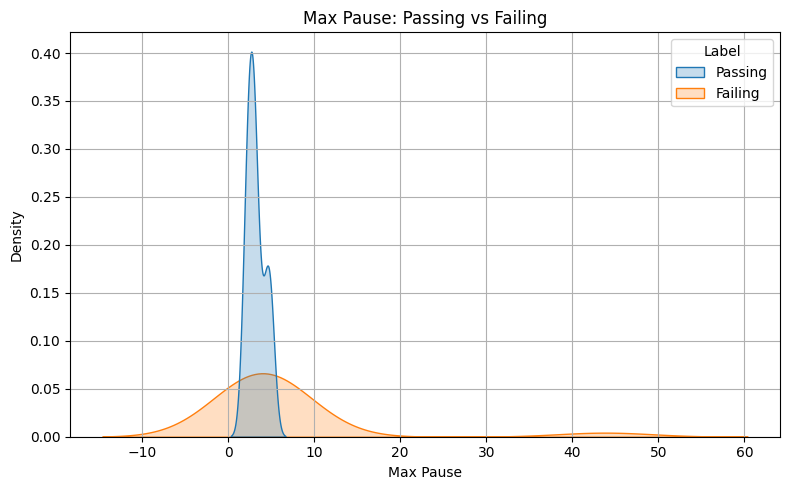

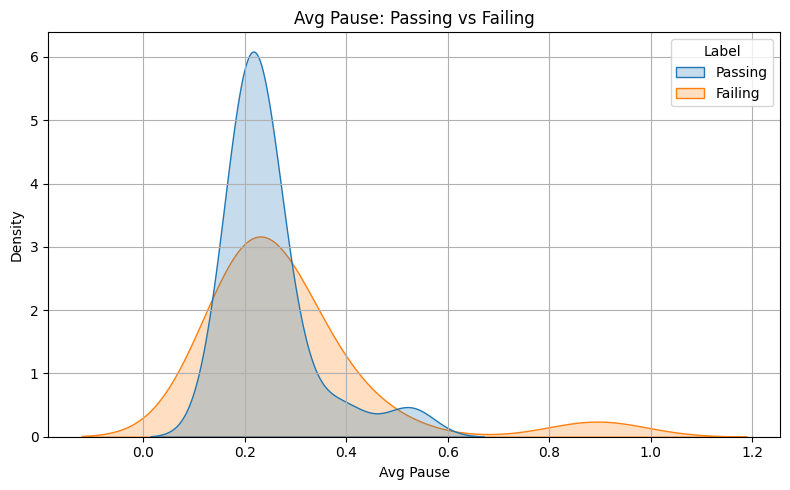

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

X_test_copy = X_test.copy()
X_test_copy["Predicted"] = y_pred
X_test_copy["Label"] = ["Passing" if score >= (5/7) else "Failing" for score in y_pred]

# Plot all feature distributions
for col in X_test.columns:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=X_test_copy, x=col, hue="Label", fill=True, common_norm=False)
    plt.title(f"{col}: Passing vs Failing")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [20]:
good_mask = y_pred >= (5/7)
bad_mask = y_pred < (5/7)

In [29]:
good_stats = X_test[good_mask].describe().T[["mean", "std"]]
bad_stats = X_test[bad_mask].describe().T[["mean", "std"]]

print("Feature Ranges for Good Scores:")
print(good_stats)

print("\nFeature Ranges for Bad Scores:")
print(bad_stats)


Feature Ranges for Good Scores:
                       mean        std
Energy             0.009610   0.003262
Pitch Min        152.356338   0.028201
Pitch Max       3995.817406   0.343104
Pitch Mean       989.273470  64.621149
Pitch Std Dev    844.331216  45.801592
Intensity Min      0.000956   0.000392
Intensity Max      0.080463   0.034975
Intensity Mean     0.009610   0.003262
Jitter           844.331216  45.801592
Shimmer            0.007931   0.002677
Speech Rate        4.373822   1.043764
Max Pause          3.212444   0.996461
Avg Pause          0.246478   0.086813

Feature Ranges for Bad Scores:
                       mean         std
Energy             0.007285    0.002695
Pitch Min        152.353044    0.009132
Pitch Max       3995.917206    0.173962
Pitch Mean       930.038257  133.811968
Pitch Std Dev    816.480155   90.327492
Intensity Min      0.000966    0.000412
Intensity Max      0.068384    0.033048
Intensity Mean     0.007285    0.002695
Jitter           816.480155   